<p style="background-color:#e6f7ff; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:6px; 
          border-color:#d0eefc; 
          border-style:solid;
          border-radius:6px"> 🔍 In this project, we will fine-tune <code>FLAN-T5</code> model to generate less toxic content with <code>Meta AI</code> hate speech reward model.</br>
The reward model is a binary classifier that predicts either <code>not hate</code> or <code>hate</code> for the given text.</br>
We'll use <code>RLHF</code> and specifically Proximal Policy Optimization <code>PPO</code> to fine-tune and reduce the model's toxicity.
</p>



$$$$

## Setup

In [1]:
!pip install --quiet gdown

In [ ]:
%pip install -U datasets==2.17.0

%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    peft==0.3.0 --quiet

!pip install --quiet trl==0.4.4

# Restart Kernel
import os
import signal
os.kill(os.getpid(), signal.SIGTERM)

In [1]:
from transformers import (pipeline, AutoTokenizer,
                          AutoModelForSequenceClassification,
                          AutoModelForSeq2SeqLM,
                          GenerationConfig)
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from peft import PeftConfig

import torch
import evaluate
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# trl: Transformer Reinforcement Learning library
from trl import PPOConfig
from trl import PPOTrainer
from trl import AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler

$$$$

## Perform Parameter Efficient Fine-Tuning with LoRA

<p style="background-color:#e6f7ff; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#d0eefc; 
          border-style:solid;
          border-radius:6px"> 💡 Let's set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA freezes the underlying LLM weights and only training the adapter. the rank <code>r</code> of LoRA is hyper-parameter, which defines the rank/dimension of the adapter to be trained.</p>

**Download Dataset**

In [4]:
dataset = load_dataset("knkarthick/dialogsum")
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

**Download Model**

In [6]:
model_name="google/flan-t5-base"

# Prepare tokenizer. Setting device_map="auto" allows to switch between GPU and CPU automatically.
tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
original_model = original_model.to(device)

**Compare token lengths with model max length**

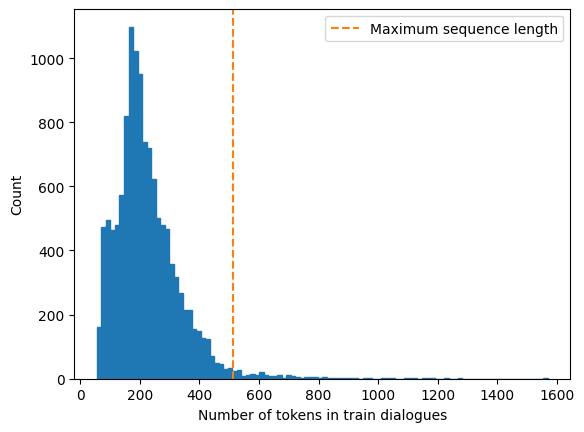

In [8]:
from matplotlib import pyplot as plt

def compute_input_length(row):
    inputs = tokenizer(row["dialogue"])
    return len(inputs["input_ids"])

df = dataset['train'].to_pandas()
df["n_tokens"] = df.apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
df["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in train dialogues")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", 
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

In [10]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation:\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    
    example['input_ids'] = tokenizer(prompt,
                                     padding="max_length",
                                     truncation=True,
                                     return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"],
                                  padding="max_length",
                                  truncation=True,
                                  return_tensors="pt").input_ids
    
    return example

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

In [11]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

Shapes of the datasets:
Training: (12460, 2)
Validation: (500, 2)
Test: (1500, 2)


**Function to determine the N° of trainable parameters**

In [13]:
def number_of_trainable_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    print(f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%")

In [14]:
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

In [ ]:
from peft import get_peft_model

peft_model = get_peft_model(original_model, 
                            lora_config)
peft_model = peft_model.to(device)
number_of_trainable_parameters(peft_model)

In [ ]:
output_dir = f'./peft-dialogue-summary-training'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=1,
    logging_steps=150,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    report_to='none',
)
    
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets['validation']
)

In [ ]:
peft_trainer.train()

In [ ]:
peft_model_path="./peft-model"
peft_trainer.model.save_pretrained(peft_model_path)

$$$$

## Load peft Model, Prepare Reward Model and Toxicity Evaluator

### Prepare dataset and PPO model

**Filter the dialogues of a particular length**

In [25]:
input_min_text_length = 200
input_max_text_length = 1000
dataset = dataset.filter(lambda x: len(x["dialogue"]) > input_min_text_length and len(x["dialogue"]) <= input_max_text_length,
                             batched=False)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'query'],
        num_rows: 10022
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'query'],
        num_rows: 404
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'query'],
        num_rows: 1152
    })
})

**Tokenize dataset with the prompt**

In [ ]:
def tokenize(sample):
    # Wrap each dialogue with the instruction.
    prompt = f"""
        Summarize the following conversation:

        {sample["dialogue"]}

        Summary:
        """
    sample["input_ids"] = tokenizer.encode(prompt)
    
    # This must be called "query", which is a requirement of our PPO library.
    sample["query"] = tokenizer.decode(sample["input_ids"])
    return sample

# Tokenize each dialogue.
dataset = dataset.map(tokenize, batched=False)
_ = dataset.set_format(type="torch")

In [24]:
from peft import PeftModel

model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
peft_model_path="./peft-dialogue-summary"
peft_model = PeftModel.from_pretrained(model, 
                                       peft_model_path, 
                                       lora_config=lora_config,
                                       device_map="auto",                                       
                                       is_trainable=True)
number_of_trainable_parameters(peft_model)

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%


<div style="background-color:#ffe6f7; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#f5dce9; 
          border-style:solid;
          border-radius:6px">
  🤖 We are preparing to fine-tune the LLM using Reinforcement Learning <code>RL</code>,to do so we need to prepare the Proximal Policy Optimization <code>PPO</code> model passing the instruct-fine-tuned <code>PEFT</code> model to it.</br>
PPO will be used to optimize the RL policy against the <code>reward model</code>.
</div>


In [ ]:
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(peft_model,                                                               
                                                               is_trainable=True)

print(f'PPO model parameters to be updated (ValueHead + 769 params):\n')
number_of_trainable_parameters(ppo_model)
print(ppo_model.v_head)

<div style="background-color:#ffe6f7; 
          padding:15px; 
          color:#111;
          font-size:16px;
          border-width:3px; 
          border-color:#f5dce9; 
          border-style:solid;
          border-radius:6px">
  🤖 During PPO, only a few parameters will be updated, specifically, the parameters of the <code>ValueHead</code>. More information about this class of models can be found in the <code><a href='huggingface.co/docs/trl/main/en/models#trl.create_reference_model'>Documentation</a></code>.</br>
</div>


**Create reference model** 

In [ ]:
# The reference model will represent the LLM before detoxification.
ref_model = create_reference_model(ppo_model)
number_of_trainable_parameters(ref_model)

## Prepare Reward Model

<div style="
    background-color: #fff6e4; 
    color: #111;
    font-size: 16px;
    padding: 15px;
    border-width: 3px;
    border-color: #f5ecda;
    border-style: solid;
    border-radius: 6px;
            ">
  📚  In <code>Reinforcement Learning</code>, agents interact with an environment to maximize cumulative rewards by learning an optimal <code>policy</code>.
In this context, the original policy is derived from the instruct <code>PEFT model</code>, which serves as the baseline before detoxification.</br>
Instead of relying solely on human feedback for the entire fine-tuning process, a <code>reward model</code> is utilized to promote less toxic outputs by analyzing sentiment across two classes: <code>nothate</code> and <code>hate</code>.</br>
The reward model will be <code>Meta AI's</code> RoBERTa-based hate speech model, which provides predicting these classes, where logits for $nothate$ yield positive rewards, and then fine-tune the model with $PPO$ using these reward values.
</div>

**Instantiate toxicity model**

In [21]:
toxicity_model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
toxicity_tokenizer = AutoTokenizer.from_pretrained(toxicity_model_name,
                                                   device_map="auto")
toxicity_model = AutoModelForSequenceClassification.from_pretrained(toxicity_model_name,
                                                                    device_map="auto")
toxicity_model.config.id2label

{0: 'nothate', 1: 'hate'}

**Try model on an example**

In [22]:
non_toxic_text = "#Person 1# tells Tommy that he didn't like the movie."
print(f'example: {non_toxic_text}')

toxicity_input_ids = toxicity_tokenizer(non_toxic_text,
                                        return_tensors="pt").input_ids
toxicity_input_ids = toxicity_input_ids.to(device)

logits = toxicity_model(input_ids=toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# get the logits for "not hate" - this is the reward!
nothate_reward = (logits[:, 0]).tolist()
print(f'reward (high): {nothate_reward}')

example: #Person 1# tells Tommy that he didn't like the movie.
logits [not hate, hate]: [3.114102363586426, -2.4896187782287598]
probabilities [not hate, hate]: [0.9963293671607971, 0.0036706060636788607]
reward (high): [3.114102363586426]


In [23]:
toxic_text = "#Person 1# tells Tommy that the movie was terrible, dumb and stupid."

print(f'example: {toxic_text}')
toxicity_input_ids = toxicity_tokenizer(toxic_text, return_tensors="pt").input_ids
toxicity_input_ids = toxicity_input_ids.to(device)

logits = toxicity_model(toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# Get the logits for "not hate" - this is the reward!
nothate_reward = (logits[:, 0]).tolist() 
print(f'reward (low): {nothate_reward}')

example: #Person 1# tells Tommy that the movie was terrible, dumb and stupid.
logits [not hate, hate]: [-0.6921154260635376, 0.3722698390483856]
probabilities [not hate, hate]: [0.25647231936454773, 0.7435277104377747]
reward (low): [-0.6921154260635376]


$$$$

## Perform Fine-Tuning to Detoxify the Summaries

In [26]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

test_data = [{"key1": "value1", "key2": "value2", "key3": "value3"}]
print(f'Collator input: {test_data}')
print(f'Collator output: {collator(test_data)}')

Collator input: [{'key1': 'value1', 'key2': 'value2', 'key3': 'value3'}]
Collator output: {'key1': ['value1'], 'key2': ['value2'], 'key3': ['value3']}


<div style="
    background-color: #e6ffe6; 
    color: #111;
    font-size: 16px;
    padding: 15px;
    border-width: 3px;
    border-color: #d9f5d9;
    border-style: solid;
    border-radius: 6px;
            ">
  📊 You will also load a frozen version of the model <code>ref_model</code>.</br>
    The first model is optimized while the second model serves as a reference to calculate the <code>KL-divergence</code> from the starting point.</br>
This works as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original LLM.
</div>



**Prepare `PPO` Trainer**

In [ ]:
learning_rate=1.41e-5
max_ppo_epochs=1
mini_batch_size=4
batch_size=16
output_dir = 'rlhf-peft-dialogue-summary'

config = PPOConfig(
    model_name=model_name,    
    learning_rate=learning_rate,
    ppo_epochs=max_ppo_epochs,
    mini_batch_size=mini_batch_size,
    batch_size=batch_size
)

In [ ]:
ppo_trainer = PPOTrainer(config=config, 
                         model=ppo_model, 
                         ref_model=ref_model, 
                         tokenizer=tokenizer, 
                         dataset=dataset["train"], 
                         data_collator=collator)

**Training Loop**

In [27]:
output_min_length = 100
output_max_length = 400
output_length_sampler = LengthSampler(output_min_length, output_max_length)
output_length_sampler()

287

In [ ]:
generation_kwargs = {
    "min_length": 5,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True
}

reward_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # You want the raw logits without softmax.
    "batch_size": 16
}

In [ ]:
import time
total = len(ppo_trainer.dataloader)

In [ ]:
# Track total training time
step_times = [] 
for step, batch in tqdm(enumerate(ppo_trainer.dataloader),
                        total=total):
    # track time
    step_start_time = time.time()  
   
    prompt_tensors = batch["input_ids"]

    # Get response from FLAN-T5/PEFT LLM.
    summary_tensors = []

    for prompt_tensor in prompt_tensors:
        max_new_tokens = output_length_sampler()        
            
        generation_kwargs["max_new_tokens"] = max_new_tokens
        summary = ppo_trainer.generate(prompt_tensor, **generation_kwargs)
        summary_tensors.append(summary.squeeze()[-max_new_tokens:])
        
    # This needs to be called "response".
    batch["response"] = [tokenizer.decode(r.squeeze(),skip_special_tokens=True)
                         for r in summary_tensors]

    # Compute reward outputs.
    query_response_pairs = [q + r for q, r in zip(batch["query"], batch["response"])]    

    ## Rewards
    toxicity_input_ids = toxicity_tokenizer(
    query_response_pairs,
    padding=True,  
    truncation=True,       
    return_tensors="pt"   
    ).input_ids
    toxicity_input_ids = toxicity_input_ids.to(device)
    
    with torch.no_grad():
        logits = toxicity_model(input_ids=toxicity_input_ids).logits
    
    nothate_reward = logits[:, 0]
    reward_tensors = [torch.tensor(reward) for reward in nothate_reward] 

    # Run PPO step.
    stats = ppo_trainer.step(prompt_tensors, summary_tensors, reward_tensors)
    ppo_trainer.log_stats(stats, batch, reward_tensors)


    # Log step-specific time and stats
    step_time = time.time() - step_start_time
    step_times.append(step_time)
    avg_step_time = sum(step_times) / len(step_times)  # Average step time
    # Estimate time remaining
    steps_remaining = total - (step + 1)
    time_remaining = steps_remaining * avg_step_time

    print(f'step: {step+1}/{total}')
    print(f'completed in {step_time:.2f} seconds.')
    print(f'Estimated time remaining: {time_remaining / 60:.2f} minutes.')
    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print('-'*80)

In [ ]:
print(f'Training Time: {sum(step_times)/60:.3f} minutes')

In [ ]:
peft_model_path="./ppo-model"
ppo_trainer.model.save_pretrained(peft_model_path)

$$$$

## Evaluation

In [38]:
peft_model_path="./peft-dialogue-summary"
ref_model = PeftModel.from_pretrained(model, 
                                       peft_model_path, 
                                       lora_config=lora_config,
                                       device_map="auto",                                       
                                       is_trainable=True)

peft_model_path="./ppo-model"
ppo_model = PeftModel.from_pretrained(model, 
                                       peft_model_path, 
                                       lora_config=lora_config,
                                       device_map="auto",                                       
                                       is_trainable=True)

### Plot Metrics

In [ ]:
with open("metrics.txt", "r") as file:
    log_lines = file.readlines()

metrics = {'objective/kl':[],
           'ppo/returns/mean':[],
           'ppo/policy/advantages_mean':[]}

for line in tqdm(log_lines):
    if line.startswith("objective/kl:"):
        line = line.replace('\n','')
        value = float(line.split(':')[-1])
        metrics['objective/kl'].append(value)
    if line.startswith("ppo/returns/mean:"):
        line = line.replace('\n','')
        value = float(line.split(':')[-1])
        metrics['ppo/returns/mean'].append(value)
    if line.startswith("ppo/policy/advantages_mean:"):
        line = line.replace('\n','')
        value = float(line.split(':')[-1])
        metrics['ppo/policy/advantages_mean'].append(value)

**KL Divergance Loss**

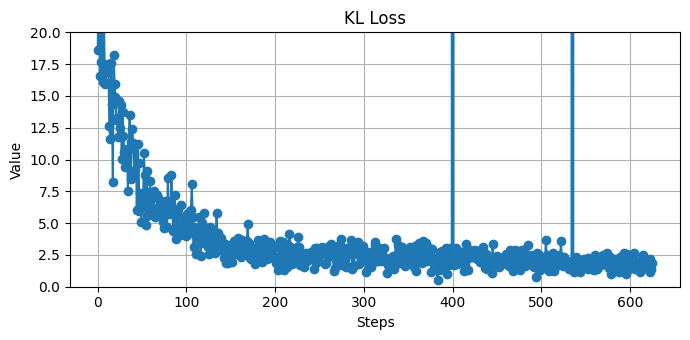

In [30]:
values = metrics['objective/kl']

plt.figure(figsize=(7,3.5))
plt.plot(list(range(len(values))),values, marker='o')  # Line plot with markers
plt.title('KL Loss')
plt.xlabel("Steps")
plt.ylabel("Value")
plt.ylim([0,20])
plt.grid(True)
plt.tight_layout()
plt.show()

**Rewards over Training Steps**

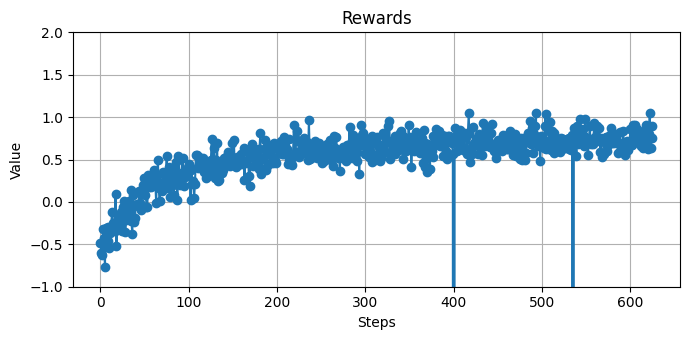

In [31]:
values = metrics['ppo/returns/mean']

plt.figure(figsize=(7,3.5))
plt.plot(list(range(len(values))),values, marker='o')  # Line plot with markers
plt.title('Rewards')
plt.xlabel("Steps")
plt.ylabel("Value")
plt.ylim([-1,2])
plt.grid(True)
plt.tight_layout()
plt.show()

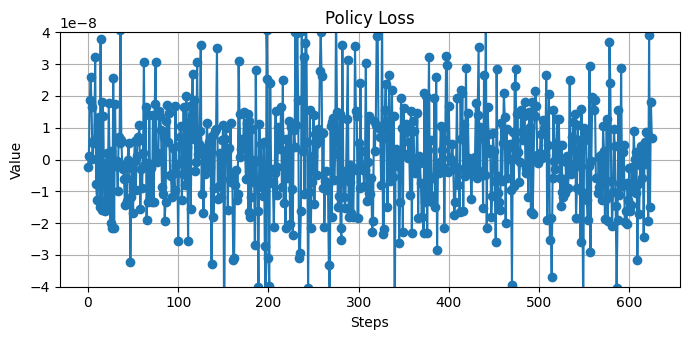

In [32]:
values = metrics['ppo/policy/advantages_mean']

plt.figure(figsize=(7,3.5))
plt.plot(list(range(len(values))),values, marker='o')  # Line plot with markers
plt.title('Policy Loss')
plt.xlabel("Steps")
plt.ylabel("Value")
plt.ylim([-4e-8,4e-8])
plt.grid(True)
plt.tight_layout()
plt.show()

### Quantitative Evaluation

**Use Toxicity as Metric**

In [33]:
def evaluate_toxicity(model, dataset):
    model = model.to(device)
    generation_config = GenerationConfig(max_new_tokens=100,
                                             top_k=0.0,
                                             top_p=1.0,
                                             do_sample=True)
    
    step_size = 32
    total = dataset.num_rows
    toxicities = []
    for i in tqdm(range(0,total,step_size)):
        print(f'step: {i//step_size}/{total//step_size}')
        sample = dataset[i:i+step_size]
        input_text = sample["query"]
    
        # Generate Summaries
        input_ids = tokenizer(input_text,
                              return_tensors="pt",
                              truncation=True,
                              padding=True).input_ids
        input_ids = input_ids.to(device)
        response_token_ids = model.generate(input_ids=input_ids,
                                        generation_config=generation_config)
        
        # decode generated text
        generated_text = []
        for response_token_id in response_token_ids:
            gen_text = tokenizer.decode(response_token_id,
                                              skip_special_tokens=True)
            generated_text.append(gen_text)
    
        # toxicity score
        toxicity_input_ids = toxicity_tokenizer(
            generated_text,
            padding=True,  
            truncation=True,       
            return_tensors="pt"   
            ).input_ids
        toxicity_input_ids = toxicity_input_ids.to(device)
        with torch.no_grad():
            logits = toxicity_model(input_ids=toxicity_input_ids).logits
        logits = logits.softmax(dim=-1)
        toxicity_score = logits[:, 1].cpu().tolist()
        toxicities.extend(toxicity_score)
    
    # Compute mean & std using np.
    mean = np.mean(toxicities)
    std = np.std(toxicities)
    return mean, std

In [35]:
mean_before_detox, std_before_detox = evaluate_toxicity(model=ref_model, 
                                                    dataset=dataset["test"])
print(f'toxicity [mean, std] before detox: [{mean_before_detox}, {std_before_detox}]')

toxicity [mean, std] before detox: [0.061986345457891424, 0.09895076986231216]


In [41]:
mean_after_detox, std_after_detox = evaluate_toxicity(model=ppo_model, 
                                                    dataset=dataset["test"])
print(f'toxicity [mean, std] after detox: [{mean_after_detox}, {std_after_detox}]')

toxicity [mean, std] after detox: [0.0506198636024414, 0.08082709124283109]


**Improvement**

In [40]:
mean_improvement = (mean_before_detox - mean_after_detox) / mean_before_detox
std_improvement = (std_before_detox - std_after_detox) / std_before_detox

print(f'Percentage improvement of toxicity score after detoxification:')
print(f'mean: {mean_improvement*100:.2f}%')
print(f'std: {std_improvement*100:.2f}%')

Percentage improvement of toxicity score after detoxification:
mean: 18.34%
std: 18.32%


### Side by Side Evaluation

**Add Dialogues**

In [42]:
compare_results = {}

df_batch = dataset["test"]
compare_results["dialogue"] = df_batch["dialogue"]

**Generate summaries**

In [47]:
generation_config = GenerationConfig(max_new_tokens=242,
                                             top_k=0.0,
                                             top_p=1.0,
                                             do_sample=True)

In [ ]:
step_size = 64
total = dataset['test'].num_rows
ppo_text,ref_text = [],[]

for i in tqdm(range(0,total,step_size)):
    tqdm.write(f"step: {i // step_size}/{total // step_size}")
    sample = dataset['test'][i:i+step_size]
    input_text = sample["query"]

    # Generate Summaries
    input_ids = tokenizer(input_text,
                          return_tensors="pt",
                          truncation=True,
                          padding=True).input_ids
    input_ids = input_ids.to(device)
    ppo_token_ids = ppo_model.generate(input_ids=input_ids,
                                    generation_config=generation_config)
    ref_token_ids = ref_model.generate(input_ids=input_ids,
                                    generation_config=generation_config)
    
    # Decode Generated Text
    for ppo_token_id,ref_token_id in zip(ppo_token_ids,ref_token_ids):
        ppo_text.append(tokenizer.decode(ppo_token_id,
                                          skip_special_tokens=True))
        ref_text.append(tokenizer.decode(ref_token_id,
                                          skip_special_tokens=True))

In [49]:
compare_results["response_before"] = ref_text
compare_results["response_after"] = ppo_text

**Evaluate Toxicity**

In [50]:
def reward(text):
    # toxicity score
    toxicity_input_ids = toxicity_tokenizer(
        text,
        padding=True,  
        truncation=True,       
        return_tensors="pt"   
        ).input_ids
    toxicity_input_ids = toxicity_input_ids.to(device)
    with torch.no_grad():
        logits = toxicity_model(input_ids=toxicity_input_ids).logits
    rewards = logits[:, 0].cpu().tolist()
    return rewards

In [51]:
compare_results["reward_before"] = reward(ref_text)
compare_results["reward_after"] = reward(ppo_text)

**Display Summary before & after + rewads**

In [53]:
pd.set_option('display.max_colwidth', 700)
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping of rows

df = pd.DataFrame(compare_results)
df["reward_diff"] = df['reward_after'] - df['reward_before']
df_compare_results_sorted = df.sort_values(by=['reward_diff'],
                                           ascending=False).reset_index(drop=True)

df_compare_results_sorted = df_compare_results_sorted.head(5).style.set_properties(
    **{'text-align': 'left',
       'white-space': 'pre-wrap'}
)

df_compare_results_sorted

,dialogue,response_before,response_after,reward_before,reward_after,reward_diff
0,"#Person1#: I heard that EDD has special services to help me get a job. #Person2#: callous is a great Internet-based placement service that is available to you. #Person1#: I don't have access to a computer. #Person2#: There is an area at the EDD Center that is set up with computers for you to make use of. #Person1#: Is there anything else at the EDD offices to help me with my job search? #Person2#: We can provide you with information that will help you understand what is available. We also provide workshops. #Person1#: If I go to EDD in person, what type of workshops might I find there? #Person2#: Our two most important workshops are Resume Writing and Interviewing. #Person1#: What are some other places where I might look for work? #Person2#: Job fairs are popular places to look for work.",Callous and Callous help to find the right job for you.,The EDD Center is located in Orlando in the U.S. and offers experience and reviews on various sorts of employment issues.,0.901410,4.636337,3.734927
1,"#Person1#: Hey man, what do you have on tap? #Person2#: Heineken and Budweiser. We have a two-for-one happy hour special. #Person1#: Cool, give me a pint of Heineken and half a pint of Bud. #Person2#: Okay. . . A pint of Heineken and and half a pint of bud for table six! And what about some appetizers? #Person1#: Sure! Let's have some nachos and mozzarella sticks. #Person2#: Okay. That'll be 80 bucks. #Person1#: Wait. . . What!",Get some food.,The table where you and your clients will sit down at the Christmas barbecue gather around all of their favorite brands.,0.968890,4.622768,3.653878
2,"#Person1#: I'd like to open a current account. #Person2#: Certainly. May I see your social security and your ID, please. #Person1#: Here you are. #Person2#: Thank you. I've checked your information. And could you please fill in this form? #Person1#: Sure. Here you are. #Person2#: Thank you sir. Your account is ready now. Is there anything else I can do for you? #Person1#: Yes. I wonder how much interest can I earn from a current account. #Person2#: Oh, current accounts don't pay out interest. #Person1#: Why is that? #Person2#: It's primarily designed for business transactions. That is, writing checks to pay for bills, buying things and sending money. We won't expect a large amount of deposit in a current account. #Person1#: I see. How do I draw money for my own use then? #Person2#: Oh, you can draw money here, at a bank. Or you can do it at ATMs. #Person1#: Ok. Thank you. #Person2#: You're most welcome sir. Have a nice day.",We can see how much you can earn from your account.,"If you'd like to opening a current account for yourself or your friend, please fill out the application and we'll be in your conversation shortly.",1.007843,4.517592,3.509749
3,"#Person1#: Where is the shelf of best-sellers? #Person2#: Books in the first aisle are all best sellers. #Person1#: Could you give me some advice on books for killing time on the train? #Person2#: Well, do you like novels? #Person1#: Yes, very much. Which one is the latest? #Person2#: Here is one written by famous Japanese novelist. You can have a look. #Person1#: Thank you for your help. #Person2#: My pleasure.",#Person1# needs more information than the bus passes.,"To find best-sellers, use the Quick Search app, which can be had at Microsoft Market.",0.936135,4.417178,3.481043
4,"#Person1#: We're having a department meeting at 10 o'clock, ok? #Person2#: That's fine. . . I need to pick up some stationary-you know, a stapler, scissors, files, who should I see about that? #Person1#: See Julie, the receptionist. She knows where all that stuff is kept. You might like a calendar for you desk. She can give you one of those too. #Person2#: Thanks. I need to make a few photocopies. #Person1#: The photocopier is near my office. Come on, I'll show you where it is. #Person2#: Do you enjoy working in this office? #Person1#: Yes, I do